In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import datetime


# fact table
sessions_df = pd.read_json("data/sessions.jsonl", lines=True)

# dimension tables
deliveries_df = pd.read_json("data/deliveries.jsonl", lines=True)
products_df = pd.read_json("data/products.jsonl", lines=True)
users_df = pd.read_json("data/users.jsonl", lines=True)

In [2]:
MAKE_PLOTS = True
MAKE_PAIRPLOT = True
DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"
PRICE_TRESHOLD = 100_000    # for outliers
WEIGHT_TRESHOLD = 50        # for outliers
NUM_OF_HOURS = 12
SEED = 42
SHOW_ALL_WARNINGS = False
SHOW_ONLY_ONE_WARNING = False

In [3]:
import warnings

if SHOW_ONLY_ONE_WARNING:
    warnings.filterwarnings(action='once')
elif not SHOW_ALL_WARNINGS:
    warnings.filterwarnings('ignore')

In [4]:
# 1.
deliveries_df["delivery_timestamp"] = deliveries_df["delivery_timestamp"].str.split('.', expand=True)[0]

# 2.
deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format=DATE_FORMAT)
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format=DATE_FORMAT)

# 3.
deliveries_df["time_diff"] = deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"]

# 4.
deliveries_df = deliveries_df[deliveries_df["time_diff"].notna()]

# 5.
# time diff as duration in seconds
deliveries_df["time_diff"] = deliveries_df["time_diff"].apply(datetime.timedelta.total_seconds)

# 6.
# deliveries_df = deliveries_df[deliveries_df["time_diff"] >= 0]

In [5]:
# drop rows where event_type is not equal "BUY_PRODUCT"
sessions_df = sessions_df[sessions_df["event_type"] == "BUY_PRODUCT"]
df = deliveries_df.merge(sessions_df, on="purchase_id", how="left")

In [6]:
# making sure, that timestamp == purchase_timestamp
num_of_rows_before = df.shape[0]
df = df[df["timestamp"] == df["purchase_timestamp"]]
num_of_rows_after = df.shape[0]

assert(num_of_rows_before == num_of_rows_after)

# now we can drop timestamp column, as it is redundant
df = df.drop(columns="timestamp")

In [7]:
df = df.merge(users_df, on="user_id", how="left")
df = df.merge(products_df, on="product_id", how="left")

In [8]:
# rejecting outliers for given PRICE_TRESHOLD
df = df[df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
df = df[df["weight_kg"] <= WEIGHT_TRESHOLD]

In [9]:
# deleting rows with prices below 0
df = df[df["price"] >= 0]

In [10]:
df_with_time_diff_below_0 = df
df = df[df["time_diff"] >= 0]

In [11]:
df['day_of_week'] = df['purchase_timestamp'].dt.dayofweek

In [12]:
df['city_and_street'] = df['city'] + ' ' + df['street']
display(df[['city_and_street', 'city', 'street']])

,city_and_street,city,street
0,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
1,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
2,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
3,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
4,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
...,...,...,...
12423,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
12424,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
12425,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
12426,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88


In [13]:

df['purchase_datetime_delta'] = (df['purchase_timestamp'] - df['purchase_timestamp'].min())  / np.timedelta64(1,'D')

In [14]:
# drop columns
ADDITIONAL_COLUMNS_TO_DROP = ["delivery_timestamp",
                              "session_id",
                              "purchase_id",
                              "event_type",
                              "name",
                              "city_and_street",
                              "brand",
                              "user_id",
                              'product_name',
                              'offered_discount']
df = df.drop(columns=ADDITIONAL_COLUMNS_TO_DROP)
df = df.drop(columns="optional_attributes") # chyba do zmiany - wysokosc itp.
df = df.drop(columns="purchase_timestamp") # na pewno do zmiany

In [15]:
def one_hot_encode_a_col_in_pd(df, col_name):
    one_hot = pd.get_dummies(df[col_name], drop_first=True)
    df = df.drop(columns=col_name)
    df = df.join(one_hot)
    return df

In [16]:
COLUMNS_TO_ONE_HOT = ["delivery_company", "city", "category_path", "street", 'day_of_week', 'product_id']

for col_name in COLUMNS_TO_ONE_HOT:
    df = one_hot_encode_a_col_in_pd(df, col_name)

In [17]:
df = df.dropna()
print(df.shape)
# one-hot encoding took care of missing data, so shape has not changed

(12320, 598)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12320 entries, 0 to 12427
Columns: 598 entries, time_diff to 1617
dtypes: float64(4), uint8(594)
memory usage: 7.7 MB


In [19]:
# specify columns for standardization scaling (Z-score normalization)
cols_to_std = []

# specify columns for min-max scaling
# offered_discount, price, weight_kg, purchase_datetime_delta
cols_to_min_max = ['price', 'weight_kg', 'purchase_datetime_delta']
# cols_to_min_max = ['weight_kg']

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for col in cols_to_std:
    x = df[col].values
    std_scaler = StandardScaler()
    x_scaled = std_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

for col in cols_to_min_max:
    x = df[col].values
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

In [21]:
df.head()

,time_diff,price,weight_kg,purchase_datetime_delta,516,620,Kraków,Poznań,Radom,Szczecin,...,1464,1475,1487,1535,1547,1558,1562,1588,1597,1617
0,179997.0,0.162411,0.017333,0.459102,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,169885.0,0.043912,0.000500,0.191164,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,164705.0,0.643248,0.000000,0.082217,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,220485.0,0.284985,0.019667,0.822567,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,138672.0,0.044934,0.008667,0.343056,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def split_data(df, target_column="time_diff"):
    y = df["time_diff"].to_numpy()
    X = df.drop(columns="time_diff")
    return train_test_split(X, y, test_size=0.2, random_state=SEED)

In [23]:
def train_models(models_list, X_train, y_train):
    for model in models_list:
        model.fit(X_train, y_train)
    return models_list

In [24]:
def create_df_with_predictions(models_list, X_test, y_test):
    y_pred_df = pd.DataFrame()
    y_pred_df["y_test"] = y_test
    for model in models_list:
        y_pred_df[f"{type(model).__name__} prediction"] = model.predict(X_test)
    return y_pred_df

In [25]:
def display_predictions(y_pred_df):
    display(y_pred_df.head())
    display(y_pred_df.info())
    display(y_pred_df.describe())

In [26]:
def print_scores(models_list, X_test, y_test):
    for model in models_list:
        score = model.score(X_test, y_test)
        print(f"{type(model).__name__} score = {score}")

In [27]:
def print_percent_of_good_predictions(models_list, X_test, y_test, error=NUM_OF_HOURS*60*60):
    for model in models_list:
        predictions = model.predict(X_test)
        predictions_time_diff = np.abs(y_test - predictions)
        num_of_good_predictions = (predictions_time_diff < error).sum()
        percent_of_good_predictions = num_of_good_predictions / len(predictions_time_diff)
        print(f'number of good predictions for {type(model).__name__} = {num_of_good_predictions}')
        print(f'which is {percent_of_good_predictions * 100}%')

In [28]:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor


# X_train, X_test, y_train, y_test = split_data(df)

# models_list = [Ridge(alpha=0.1),
#                Lasso(alpha=0.1),
#                DecisionTreeRegressor(random_state=SEED),
#                RandomForestRegressor(random_state=SEED)]
# models_list = train_models(models_list, X_train, y_train)

# y_pred_df = create_df_with_predictions(models_list, X_test, y_test)
# # display_predictions(y_pred_df)

# print_scores(models_list, X_test, y_test)

# print_percent_of_good_predictions(models_list, X_test, y_test)

# autokeras test

In [29]:
X_train, X_test, y_train, y_test = split_data(df)
input_shape = X_train.shape[1]

In [30]:
import autokeras as ak

clf = ak.StructuredDataRegressor(max_trials=5)
clf.fit(X_train, y_train, epochs=200)

Trial 5 Complete [00h 06m 45s]
val_loss: 2964773888.0

Best val_loss So Far: 2779446784.0
Total elapsed time: 00h 57m 35s
INFO:tensorflow:Oracle triggered exit


Epoch 1/200
308/308 [==============================] - 12s 12ms/step - loss: 55524978688.0000 - mean_squared_error: 55524978688.0000
Epoch 2/200
308/308 [==============================] - 4s 13ms/step - loss: 54191063040.0000 - mean_squared_error: 54191063040.0000
Epoch 3/200
308/308 [==============================] - 4s 13ms/step - loss: 49493114880.0000 - mean_squared_error: 49493114880.0000
Epoch 4/200
308/308 [==============================] - 5s 15ms/step - loss: 40836476928.0000 - mean_squared_error: 40836476928.0000
Epoch 5/200
308/308 [==============================] - 4s 13ms/step - loss: 29647747072.0000 - mean_squared_error: 29647747072.0000
Epoch 6/200
308/308 [==============================] - 5s 15ms/step - loss: 18699462656.0000 - mean_squared_error: 18699462656.0000
Epoch 7/200
308/308 [==============================] - 4s 14ms/step - loss: 10567519232.0000 - mean_squared_error: 10567519232.0000
Epoch 8/200
308/308 [==============================] - 5s 15ms/step - loss:

In [32]:
error = NUM_OF_HOURS * 60 * 60
predictions = clf.predict(X_test)
# predictions = np.squeeze(predictions)
predictions_time_diff = np.abs(y_test - predictions)
num_of_good_predictions = (predictions_time_diff < error).sum()
percent_of_good_predictions = num_of_good_predictions / len(predictions_time_diff)
print(f'number of good predictions for autokeras = {num_of_good_predictions}')
print(f'which is {percent_of_good_predictions * 100}%')

77/77 [==============================] - 2s 31ms/step
number of good predictions for autokeras = 2342674
which is 95076.05519480519%


In [33]:
predictions = np.squeeze(predictions)
predictions_time_diff = np.abs(y_test - predictions)
num_of_good_predictions = (predictions_time_diff < error).sum()
percent_of_good_predictions = num_of_good_predictions / len(predictions_time_diff)
print(f'number of good predictions for autokeras = {num_of_good_predictions}')
print(f'which is {percent_of_good_predictions * 100}%')

number of good predictions for autokeras = 1412
which is 57.3051948051948%


In [34]:
error = 2 * NUM_OF_HOURS * 60 * 60

In [35]:
predictions = np.squeeze(predictions)
predictions_time_diff = np.abs(y_test - predictions)
num_of_good_predictions = (predictions_time_diff < error).sum()
percent_of_good_predictions = num_of_good_predictions / len(predictions_time_diff)
print(f'number of good predictions for autokeras = {num_of_good_predictions}')
print(f'which is {percent_of_good_predictions * 100}%')

number of good predictions for autokeras = 2171
which is 88.10876623376623%


In [36]:
autokeras_model = clf.export_model()
autokeras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 597)]             0         
                                                                 
 multi_category_encoding (Mu  (None, 597)              0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 597)              1195      
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                19136     
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [40]:
from tensorflow.keras.utils import plot_model
plot_model(autokeras_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [43]:
autokeras_model.save('/regression_model',save_format="tf")

KeyboardInterrupt: 

Epoch 1/200
142/142 [==============================] - 3s 18ms/step - loss: 61303406592.0000 - mae: 233520.8906 - val_loss: 59726385152.0000 - val_mae: 231063.7344
Epoch 2/200
142/142 [==============================] - 2s 17ms/step - loss: 61231878144.0000 - mae: 233441.3125 - val_loss: 59619422208.0000 - val_mae: 230935.1562
Epoch 3/200
142/142 [==============================] - 2s 17ms/step - loss: 61098082304.0000 - mae: 233265.1875 - val_loss: 59474092032.0000 - val_mae: 230763.3438
Epoch 4/200
142/142 [==============================] - 2s 17ms/step - loss: 60901965824.0000 - mae: 232988.5000 - val_loss: 59266252800.0000 - val_mae: 230473.1250
Epoch 5/200
142/142 [==============================] - 2s 17ms/step - loss: 60645527552.0000 - mae: 232614.1250 - val_loss: 58933420032.0000 - val_mae: 229940.9062
Epoch 6/200
142/142 [==============================] - 3s 18ms/step - loss: 60329672704.0000 - mae: 232144.4062 - val_loss: 58550972416.0000 - val_mae: 229304.2031
Epoch 7/200
142/

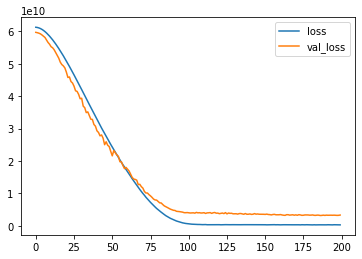

In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers, callbacks


# early_stopping = callbacks.EarlyStopping(
#     min_delta=0.001, # minimium amount of change to count as an improvement
#     patience=20, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

# model = keras.Sequential([
#     layers.BatchNormalization(input_shape=[input_shape]),

#     layers.Dense(1024, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),

#     layers.Dense(1024, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),

#     layers.Dense(1),
# ])
# model.compile(
#     optimizer='adam',
#     loss='mean_squared_error',
#     metrics=['mae']
# )

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     batch_size=64,
#     epochs=200,
#     callbacks=[early_stopping], # put your callbacks in a list
#     # verbose=0,  # turn off training log
# )

# history_df = pd.DataFrame(history.history)
# history_df.loc[:, ['loss', 'val_loss']].plot();
# print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [ ]:
error = NUM_OF_HOURS * 60 * 60
predictions = model.predict(X_test)
predictions = np.squeeze(predictions)
predictions_time_diff = np.abs(y_test - predictions)
num_of_good_predictions = (predictions_time_diff < error).sum()
percent_of_good_predictions = num_of_good_predictions / len(predictions_time_diff)
print(f'number of good predictions for {type(model).__name__} = {num_of_good_predictions}')
print(f'which is {percent_of_good_predictions * 100}%')

71/71 [==============================] - 0s 4ms/step
number of good predictions for Sequential = 1264
which is 55.85505965532479%
